## 2. PyCBC Tutorial: Visualization of Data and Signal Processing

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how to visualize LIGO/Virgo data and how to perform some basic signal processing on it, including high/low passing, psd estimation, and whitening.

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

#### Getting the software environment setup

PyCBC is installable through pip, but also relies on portions of the [LALSuite]() c-library. A bundled version of this suitable for use with PyCBC is also available on Mac / Linux through pip. These can be installed as follows within the notebook.

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

  Using cached lalsuite-6.48.1.dev20180313-cp27-cp27mu-manylinux1_x86_64.whl
Exception:
Traceback (most recent call last):
  File "/home/ahnitz/.local/lib/python2.7/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/home/ahnitz/.local/lib/python2.7/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/home/ahnitz/.local/lib/python2.7/site-packages/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/home/ahnitz/.local/lib/python2.7/site-packages/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/home/ahnitz/.local/lib/python2.7/site-packages/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/home/ahnitz/.local/lib/python2.7/site-packages/pip/wheel.py", line 345, in move_wheel_files
    clobber(source, lib_dir, True)
  File "/home/ahnitz/.local/lib/python2.7/site-packages/

#### Viewing the raw LIGO data

Below we will view the raw ligo data. You should notice that there is signifant low frequency content (indicated by the large oscilations) and even some DC offset in the data.

In [2]:
%matplotlib inline

# Read in the data around GW150914
from pycbc.catalog import Merger
import pylab

m = Merger('GW150914')

data = {}
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

##### Entire 32 seconds of data round GW150914

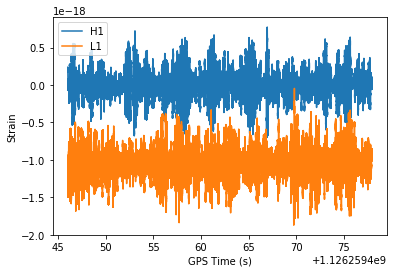

In [3]:
for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo)

pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()

##### Zoom into 1 second nearby to GW150914

When you just zoom in to one second around GW150914, all you can see is the low frequency behavior of the noise, since it is much louder than the higher frequency noise (and signal).

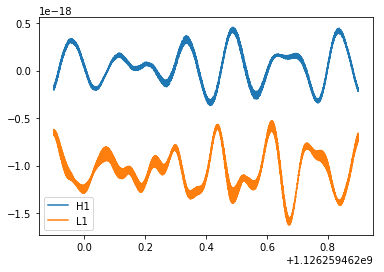

In [4]:
for ifo in data:
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = data[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

#### Highpass the data to remove the low frequency content

Below we apply a highpass filter to the data to suppress the low frequency noise of the instrument. We can see that this brings the dynamic range of the data largely into the same range. However, there is clearly still some dominant frerquencies. To equalize this, we would need to apply a whitening filter.

creating /tmp/weave-ahnitz-ya2H1w/python27_intermediate/compiler_ec1b2b3cb1185f9543a0d0512cc10169


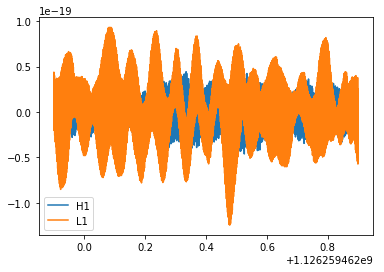

In [5]:
for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    # Options
    # 1) highpass frequency
    # 2) half sample length of highpass filter 
    #(higher value will give less ripple in passband)
    high_data = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

#### What is the power spectral density (PSD) of the data ? 

Understanding how the noise power varies over frequency is important for LIGO data analysis. In this 
section we use a version of [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)
to estimate the power spectral density of the data.

Note that there is a significant amount of noise at low frequencies (orders of magnitude). Note also that there is a large amount of power at a few specific frequencies. The causes for these include 60 Hz power line noise, violin modes of the hanging mirrors, and various other instrumental resonances. The downturn in power before 2 KHz is due to a low pass filter that was applied prior to resampling the data to 4096 Hz.

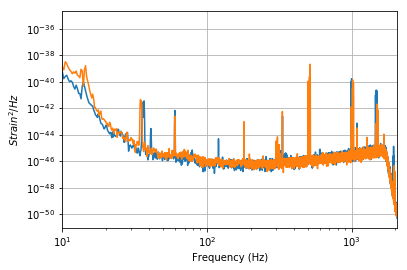

In [6]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.show()

#### Whitening the data

To visualize deviations from the noise, it is useful to "whiten" the data within some frequency range. In this way excesses in the data are visible as deviations from zero. Whitening takes the data and attempts to make the power spectral density flat, so that all frequencies contribute equally.

Below we will whiten the data, and then bandpass the result to focus on a specific frequency range.

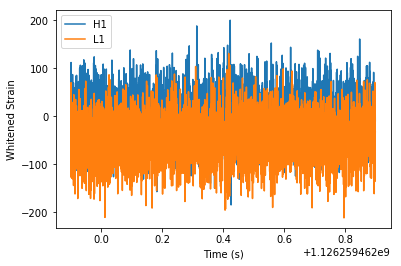

In [7]:
# Whiten the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

We will now bandpass the data around GW150914 between 30 - 250 Hz. This will remove frequency ranges which won't contribute to this kind of signal and make it possible to see the signal in question.

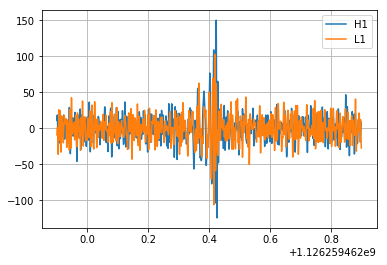

In [8]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

#### Focus the Plot around GW150914

In the above plot we can see that there is some excess signal that sticks above the noise. Let's zoom around this time now, and align the two time series.

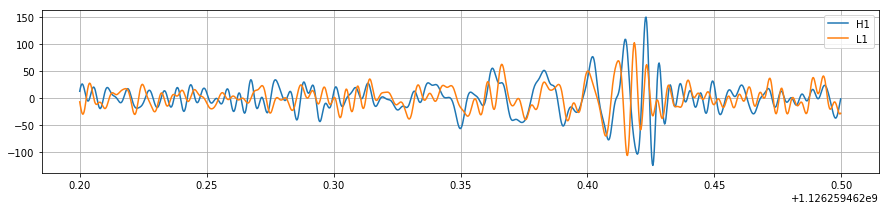

In [9]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

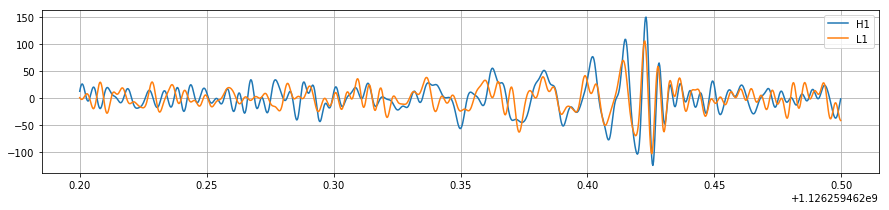

In [10]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

We can now see that there is a coherent signal that matches in phase for a few cycles, which ends at about 0.44 on the plot above. 

#### Visualizing excesses in the data with a Q-transform plot

A common way to visualize gravitational-wave data is with a time-frequency representation known as the [constant-Q transform](https://en.wikipedia.org/wiki/Constant-Q_transform). It is similar to a standard spectrogram made with short-time Fourier transforms with the advantage that frequency bins are more sparsely spaced at high freqeuncys.

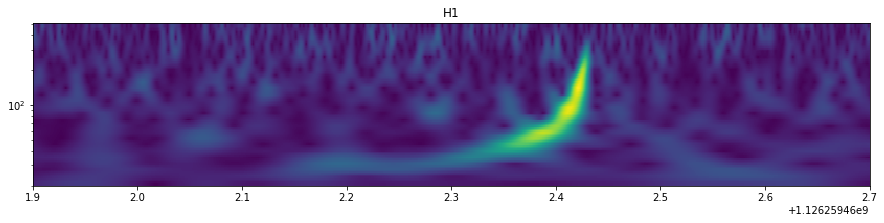

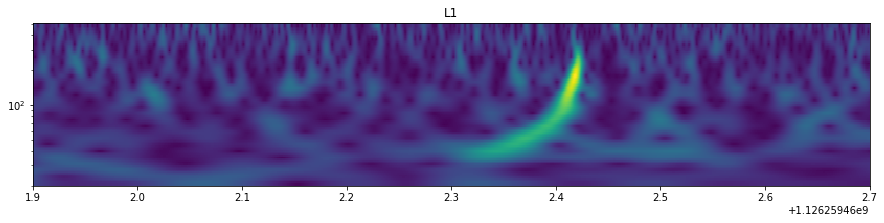

In [11]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()

The GW150914 signal is relatively clear in the qtransform output, which is why the Q-transform can be a powerful diagnostic. However, note that quieter signals, especially those with lower masses than GW150914 had, will be harder to spot visually. In practice, we use a technique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) to find signals in our data.

## Challenge!

Use the methods demonstrated above to see if you can visually spot a chirping signal in these data sets. Which of them contain a signal? Which contains just Gaussian noise?

Information that may be useful:

* Signals are all placed between 100 and 120 seconds into the frame file.
* Try whitening the data, then plotting the qtransform.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [12]:
# Download the challenge set files
import urllib

def get_file(fname):
    url = "https://github.com/ahnitz/odw-storage/raw/master/{}"
    url = url.format(fname)
    urllib.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf',
         'PyCBC_T2_3.gwf', 'PyCBC_T2_4.gwf']

for fname in files:
    get_file(fname)

Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_0.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_1.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_2.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_3.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_4.gwf


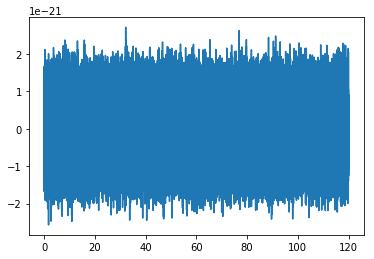

In [13]:
import pycbc.frame

# example of reading the strain in (note this is the same as in PyCBC tutorial 1)
ts = pycbc.frame.read_frame('PyCBC_T2_0.gwf', 'H1:TEST-STRAIN', 0, 128)
pylab.plot(ts.sample_times, ts)
pylab.show()